<a href="https://colab.research.google.com/github/nachozobian/Food-Vision-Mini/blob/main/FoodVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FoodVision project

This projects uses PyTorch computer vision to do Food Classification based on
images. This is a multiclass classification model. It'll be developed using device agnostic code.

In [ ]:
import torch
from torch import nn

torch.__version__

'2.0.1+cu118'

In [ ]:
#Setting up device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

**We're building a Food-Vision Mini and seeing if we're capable of developing a
model to differentiate food based on images of 101 different types.**

In [ ]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

#If the image folder doesn't exist the following code will download it
if image_path.is_dir():
  print(f"{image_path} directory already exist... skip download")
else:
  print(f"{image_path} does not exist, create one")
  image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and sushi data..")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exist... skip download
Unzipping pizza, steak and sushi data..


We'll now look a bit into the data. That's data preparation and data exploration phase

In [ ]:
import os
def walk_through_dir(dir_path):
  "Walks through directory and return its contents"
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi


In [ ]:
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

**Visualizing one single image and metadata to attain some information in order to do the data preparation part**

Random image path: data/pizza_steak_sushi/train/pizza/2800325.jpg
Image class: pizza
Image height: 512
Image width: 512


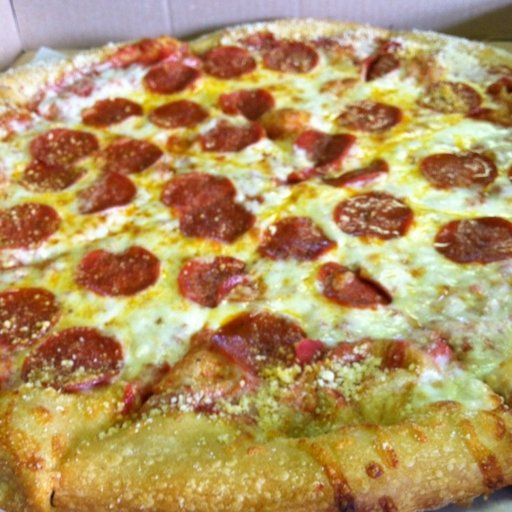

In [ ]:
import random
from PIL import Image

random.seed(14)
image_path_list = list(image_path.glob("*/*/*.jpg"))
random_image_path = random.choice(image_path_list)

#Get image class from path name
image_class = random_image_path.parent.stem

#Open image
img = Image.open(random_image_path)

#Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(-0.5, 511.5, 511.5, -0.5)

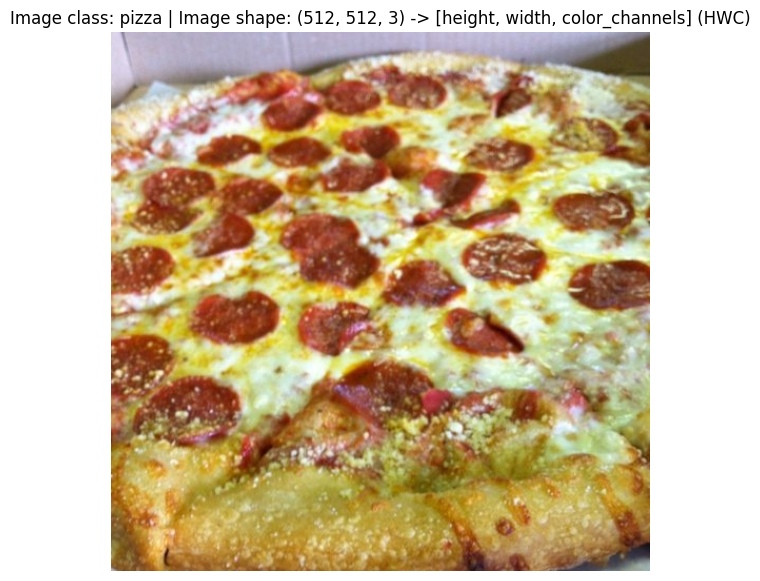

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#Image into array

img_as_array = np.asarray(img)
plt.figure(figsize = (10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels] (HWC)")
plt.axis(False)

We would like to get our data into tensor format.
1. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call this `Dataset` and `DataLoader`.


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
#Create a transform concatenation (pipelined) for dealing with this problem

data_transform = transforms.Compose([
    #Resize our images to 64x64
    transforms.Resize(size=(64,64)),
    #Flip the images (for data augmentation)
    transforms.RandomHorizontalFlip(p=0.5),
    #Turn the image into a torch tensor
    transforms.ToTensor()
])


Using ImageFolder to load all our custom dataset.

In [ ]:
from torchvision import datasets
train_data = datasets.ImageFolder(root = train_dir,
                                  transform=data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

### Turning our loaded images into `DataLoader`
A `DataLoader` is going to help us turning our dataset into iterables an then, by customizing the batch size, we can set how many images at a time we want our model to see.

In [ ]:
# Turn train and test datasets into DataLoader's (this step is the same for all sorts of data)
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size = BATCH_SIZE,
                              num_workers = os.cpu_count(),
                              shuffle=True) #This uses as many cpu as needed

test_dataloader = DataLoader(dataset=test_data,
                             batch_size= BATCH_SIZE,
                             num_workers = 1,
                             shuffle = False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7826e9edda50>,
 <torch.utils.data.dataloader.DataLoader at 0x7826e9edff40>)

In [ ]:
# Checking out the shape of our image in the dataloader

img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


## Replicating ImageLoader functionality
From this point on we'll forget we now the existance of ImageLoader and try to write our own function. Pre-built functions don't always exist and knowing how this functions work is great insight and pretty useful.

1. Want to be able to load images from file
2. Want to be able to get class names from the DataSet
3. Want to be able to get classes as dictionary from the Dataset

Pros:
* Can create a `Dataset` out of almost anything.
* Not limited to PyTorch pre-built `Dataset` functions.

Cons:
* Even though you could create `Datasets` for anythin, it doesn't mean it'll work
* It results on us writing more code... prone to errors.

All custom dataset subclass this:


https://pytorch.org/vision/stable/datasets.html

In [ ]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

#### Creating a helper function to get class names

We want a function to:
1. Get the classs names using `os.scandir()` to traverse a target directory
2. Raise an error if the class names arent found.
3. Turn the class names into a dict and a list and return them

In [ ]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory"""
  # 1. Get the class names by scanning the target directory
  classes = sorted([entry.name for entry in list(os.scandir(directory))])

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}.... check structure")

  # 3. Create a dictionary of index labels
  classes_to_idx = {class_names: i for i, class_names in enumerate(classes)}
  return classes, classes_to_idx

find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Create a custom `Dataset` to load our Images

All datasets that represent a map from keys to data samples should subclass `Dataset`. All subclasses should overwrite `__getitem()__` and optionally `__len()__`

1. Subclass `torch.utils.data.Dataset`

2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data

3. Create several attributes:
  * paths - paths of our images
  * transform - the transform we'd like to use
  * classes - a list of the target classes
  * class_to_idx - a dict of the target classes mapped to integer labels

4. Create a function to `load_images()`, this will open an image

5. Overwrite the `__len()__` method.

6. Overwrite the `__getitem()__`

In [ ]:
#Custom dataset class
from torch.utils.data import Dataset

#1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our subclass with a target_directory
  def __init__(self, targ_dir: str, transform=None):
    # 3. Create several attributes.
    #Image paths
    self.paths = list(pathlib.Path(targ_dir.glob("*/*.jpg")))
    #Transforms
    self.transform = transform
    #Create classes and class_to_idx
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_image(self, index:int)-> Image.Image:
    "Opens an image via a path and returns it"
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self) -> int:
    "Returns the total number of samples"
    return len(self.paths)

  # 6. Overwrite __getitem__()
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, y)"
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    #Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return
    else:
      return img, class_idx